In [1]:
import json

with open("./out/202003021142_spanishfn.json") as fp:
    data = json.load(fp)

In [2]:
# Compute counts
import numpy as np

counts = [
    (np.array(x["data"]).flatten(), x["id"])
    for x in data["alignments"][1:]
    if "data" in x
]

In [3]:
# Kernel density estimation
import time
from sklearn.neighbors import KernelDensity

def sample(X):
    size = len(X)
    if size > 250000:
        return X[np.random.randint(size, size=int(.2*size))]
    else:
        return X

def kde(counts, kernel="gaussian", bandwidth=.02):
    start = time.time()
    models = [
        (KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(sample(X).reshape(-1, 1)), label)
        for X, label in counts
    ]
    print("--- %s seconds ---" % (time.time() - start))
    
    return models

In [4]:
import matplotlib
import matplotlib.pyplot as plt

def plot(models):
    matplotlib.rcParams.update({'font.size': 16})

    # Estimation plotting
    fig, ax = plt.subplots(figsize=(18, 16), dpi= 80)
    plt_space = np.linspace(0, 1, 1000)[:, np.newaxis]

    for estimator, label in models:
        log_dens = estimator.score_samples(plt_space)
        ax.plot(plt_space[:, 0], np.exp(log_dens), label=label)

    plt.grid(b=True, which='major', color='#c3c3c3', linestyle='-')

    ax.legend(loc='upper right')
    ax.set_ylabel('Density')
    ax.set_xlabel('Alignment score')

--- 583.7119269371033 seconds ---


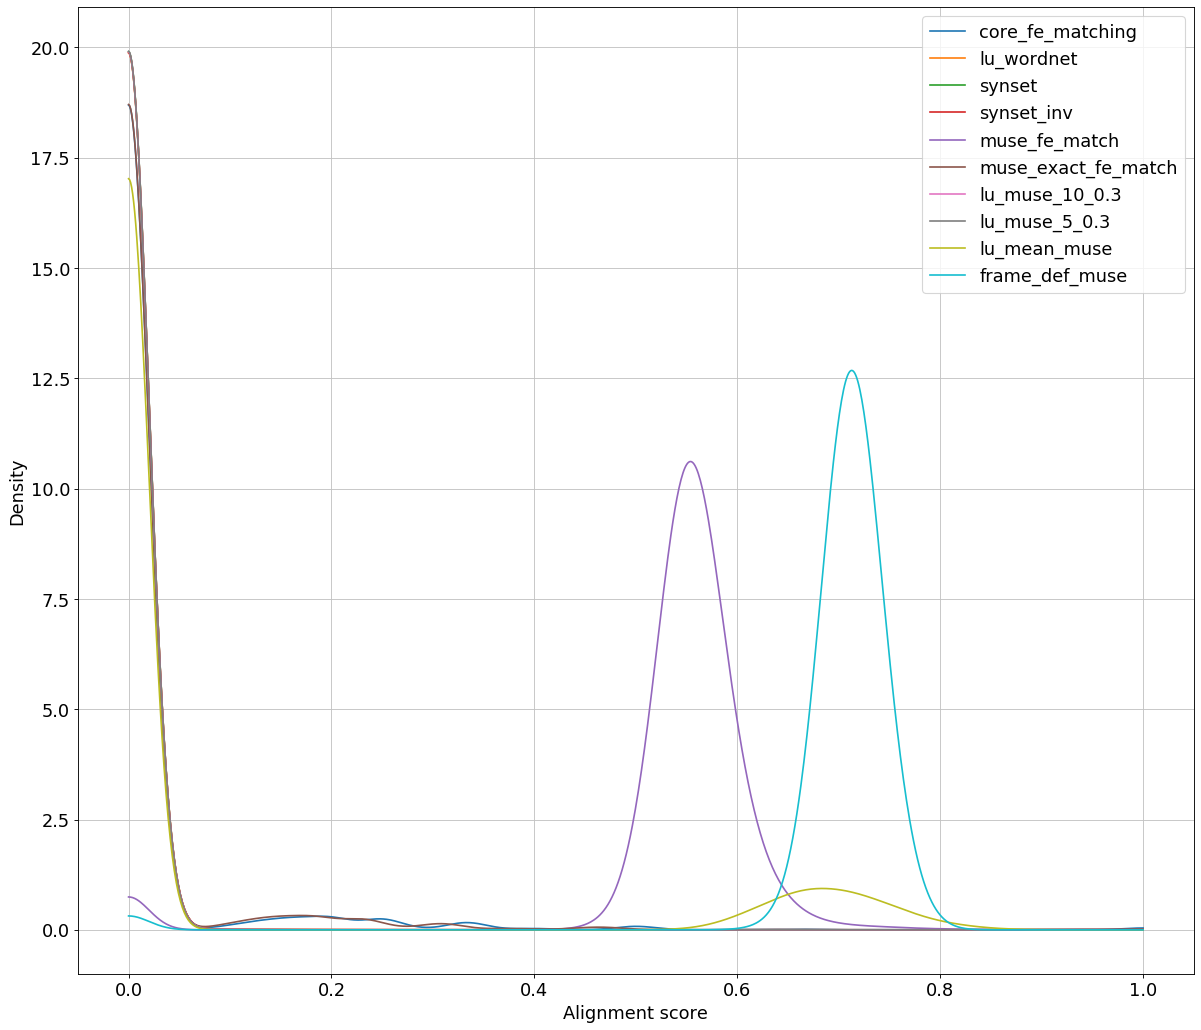

In [5]:
plot(kde(counts))

--- 601.822466135025 seconds ---


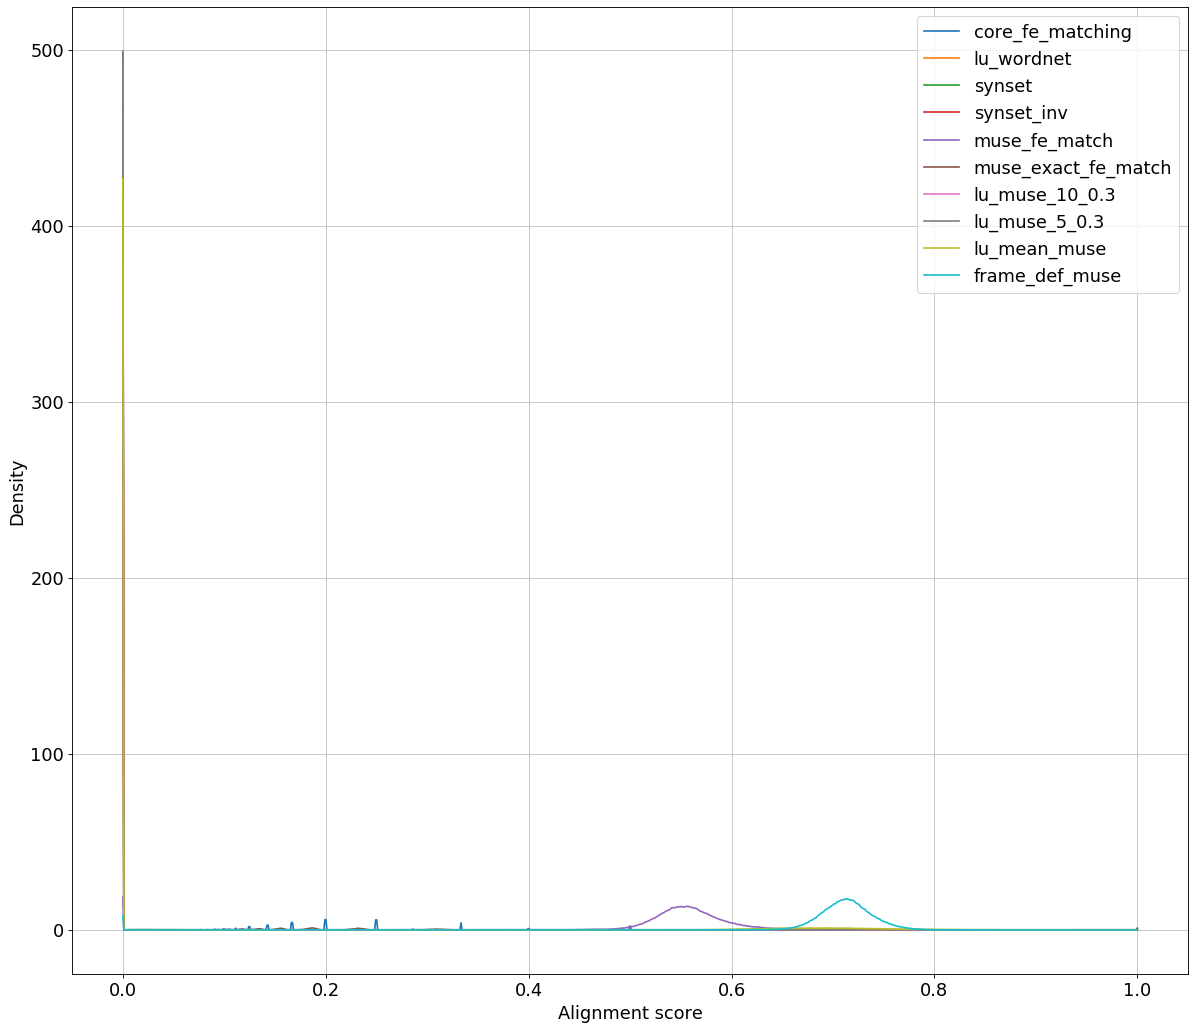

In [6]:
plot(kde(counts, kernel="tophat", bandwidth=.001))

In [7]:
import time
from sklearn.preprocessing import QuantileTransformer

sample_size=int(.2*len(counts[0][0]))
start = time.time()
scaled_quant = [
    (QuantileTransformer(n_quantiles=sample_size, subsample=sample_size).fit_transform(X.reshape(-1, 1)), label)
    for X, label in counts
]
print("--- %s seconds ---" % (time.time() - start))

In [8]:
plot(kde(scaled_quant))

In [9]:
plot(kde(scaled_quant, kernel="tophat", bandwidth=.001))

In [10]:
from scipy.stats import rankdata

def rank_transform(orig):
    data = np.copy(orig)
    indices = [i for i, s in enumerate(data) if s > 0]
    norm = rankdata([data[i] for i in indices], "max") / len(indices)

    for i, s in zip(indices, norm):
        data[i] = s
    return data

In [11]:
start = time.time()
scaled_rank = [
    (rank_transform(X), label)
    for X, label in counts
]
print("--- %s seconds ---" % (time.time() - start))

--- 6.788719892501831 seconds ---


In [14]:
scaled_rank_non0 = [
    (np.array([x for x in X if x > 0]), label)
    for X, label in scaled_rank
]

scaled_rank_non0 = [(X, label) for X, label in scaled2non0 if len(X) > 0]

--- 2.490100145339966 seconds ---


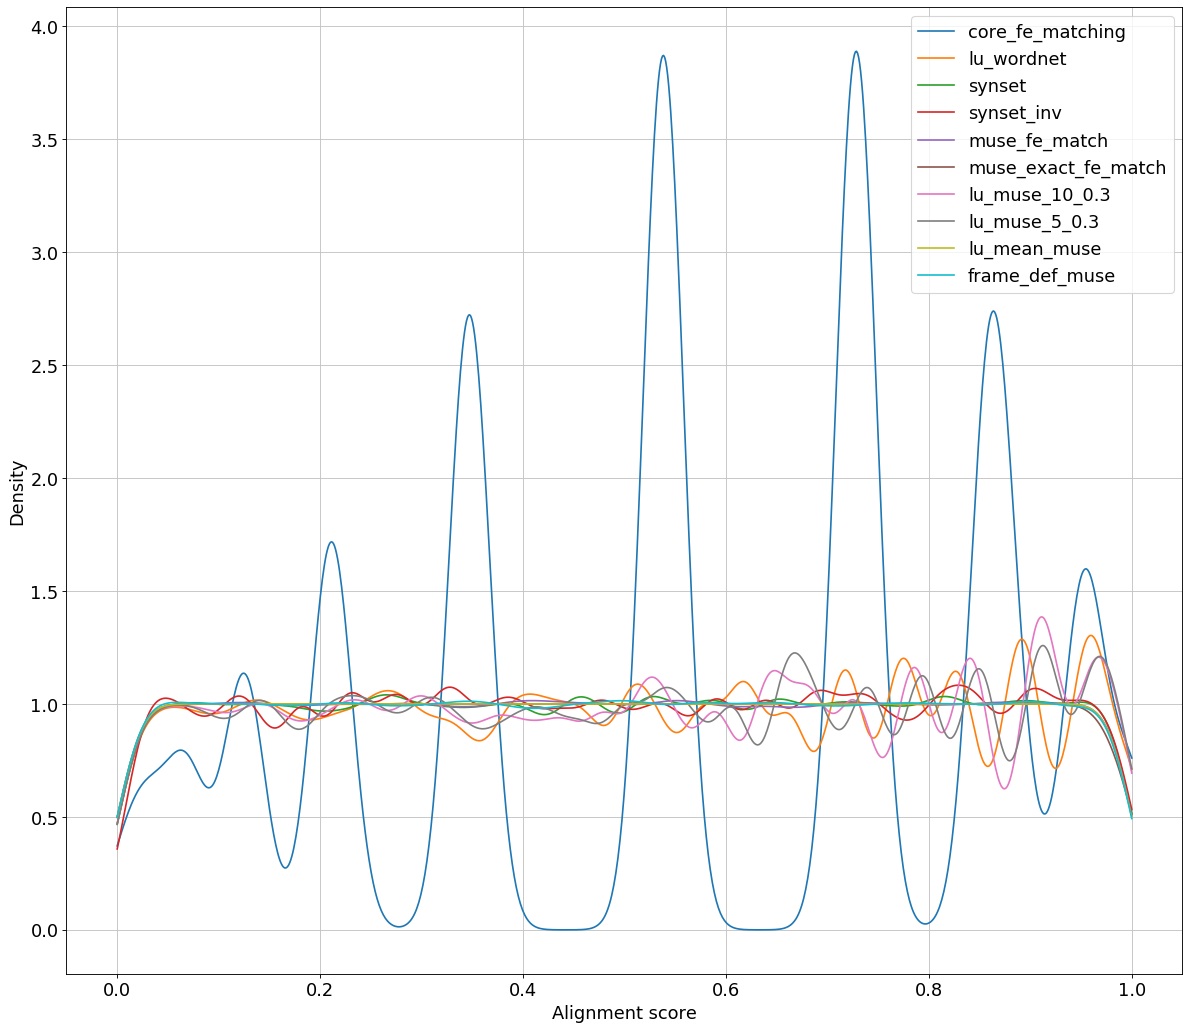

In [16]:
plot(kde(scaled_rank_non0))

--- 2.482233762741089 seconds ---


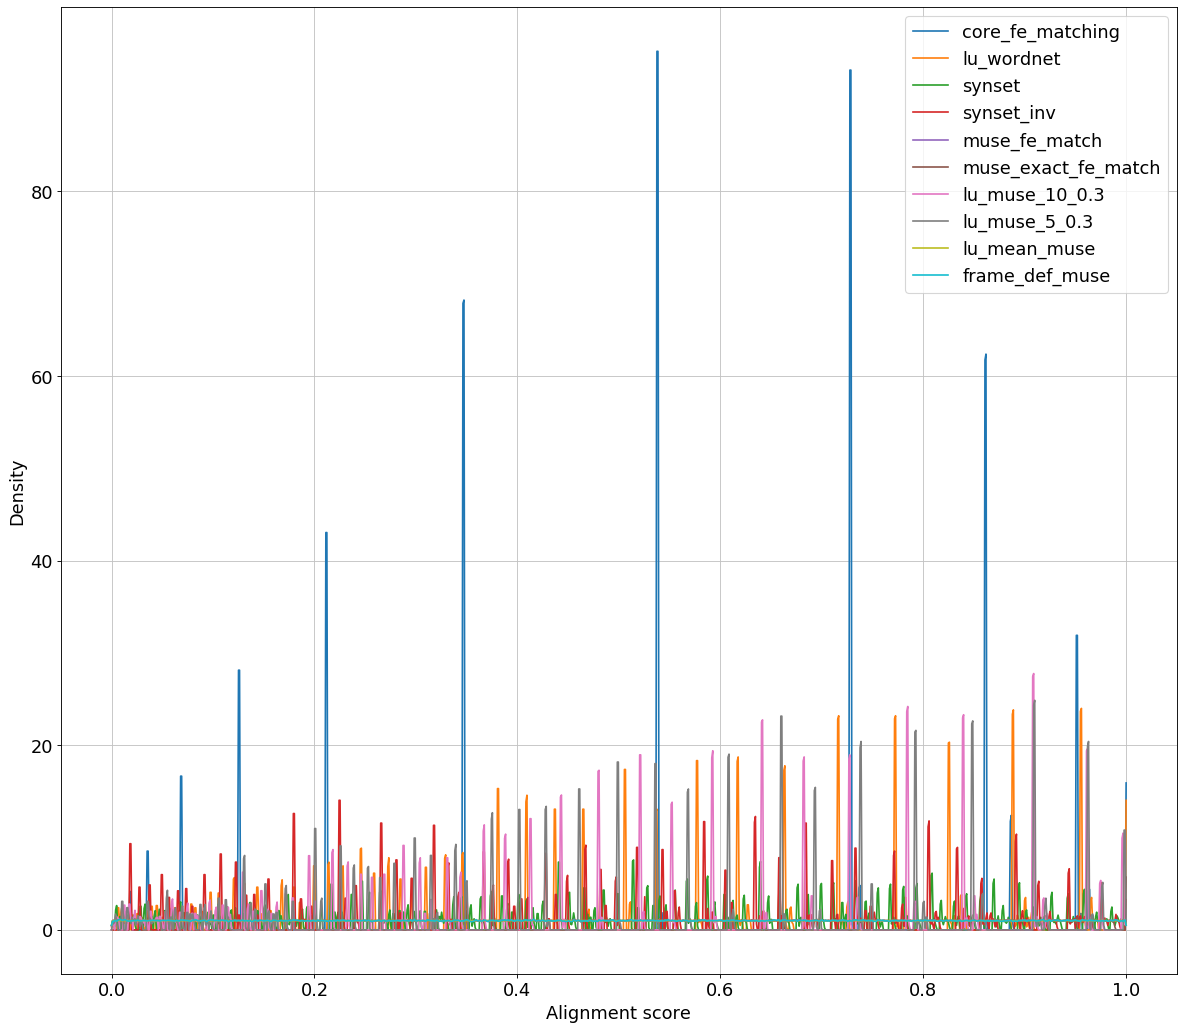

In [17]:
plot(kde(scaled_rank_non0, kernel="tophat", bandwidth=.001))